In [1]:
import numpy as np
import pandas as pd
import matplotlib, re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer 
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
tweets = pd.read_csv("vaccination_all_tweets.csv")
tweets = tweets.dropna(axis=0)
tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo",End North Stream 2 now - the pipeline of corru...,2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,it is a bit sad to claim the fame for success ...,['vaccination'],Twitter Web App,0,4,False
9,1337842295857623042,Ch.Amjad Ali,Islamabad,#ProudPakistani #LovePakArmy #PMIK @insafiansp...,2012-11-12 04:18:12,671,2368,20469,False,2020-12-12 19:30:33,#CovidVaccine \n\nStates will start getting #C...,"['CovidVaccine', 'COVID19Vaccine', 'US', 'paku...",Twitter Web App,0,0,False
10,1337841934170255365,Tamer Yazar,Turkey-Israel,"Im Market Analyst, also Editor... working (fre...",2009-09-17 16:45:16,1302,78,339,False,2020-12-12 19:29:07,"while deaths are closing in on the 300,000 mar...","['PfizerBioNTech', 'Vaccine']",Twitter Web App,0,0,False


In [3]:
# number of missing values
tweets.isnull().sum()

id                  0
user_name           0
user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
retweets            0
favorites           0
is_retweet          0
dtype: int64

In [4]:
# remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# source : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b


In [5]:
# clean text d
def clean_text(text):
    text = str.lower(text) #lower case
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+[a-zA-Z]\s+", "", text)
    text = re.sub(r"\s+[a-zA-Z]\s+", "", text)
    text = re.sub(r"\s\s+","", text)
    text = re.sub(r"#","", text)
    text = re.sub(r"[(,?!)]","", text)
    text = remove_emoji(text)
    #TODO : remove stop words or not?
    return text 

tweets["text"] = tweets["text"].apply(lambda x: clean_text(x))
tweets["text"]

0        same folks said daikon paste could treatcytoki...
2        coronavirus sputnikv astrazeneca pfizerbiontec...
6        it isbit sad to claim the fame for success of ...
9        covidvaccinestates will start getting covid19v...
10       while deaths are closing in on the 300000 mark...
                               ...                        
33708     zakharova: russia  has offered foreign embass...
33712    breakingthe information attack targeting sputn...
33713    pity as my personal preference would have been...
33714    who in close contact with russia on sputnikv c...
33716    breakingus targets europe in smear campaign ag...
Name: text, Length: 19616, dtype: object

In [6]:
print(tweets.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19616 entries, 0 to 33716
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                19616 non-null  int64 
 1   user_name         19616 non-null  object
 2   user_location     19616 non-null  object
 3   user_description  19616 non-null  object
 4   user_created      19616 non-null  object
 5   user_followers    19616 non-null  int64 
 6   user_friends      19616 non-null  int64 
 7   user_favourites   19616 non-null  int64 
 8   user_verified     19616 non-null  bool  
 9   date              19616 non-null  object
 10  text              19616 non-null  object
 11  hashtags          19616 non-null  object
 12  source            19616 non-null  object
 13  retweets          19616 non-null  int64 
 14  favorites         19616 non-null  int64 
 15  is_retweet        19616 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 2.3+ MB
None

matplotlib.axes._subplots.AxesSubplot

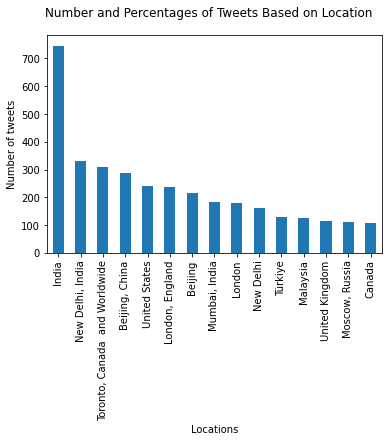

In [7]:
# EDA: plot locations 
most_location = tweets["user_location"].value_counts().head(15)
fig, ax = plt.subplots()
most_location.plot.bar()
fig.suptitle("Number and Percentages of Tweets Based on Location")
ax.set_xlabel("Locations")
ax.set_ylabel("Number of tweets")
type(ax)

In [8]:
# clean hashtags
tweets["hashtags"] = tweets["hashtags"].apply(lambda x: re.sub("'","",x))
tweets["hashtags"] = tweets["hashtags"].apply(lambda x: re.sub("\[","",x))
tweets["hashtags"] = tweets["hashtags"].apply(lambda x: re.sub("\]","",x))
tweets["hashtags"] = tweets["hashtags"].apply(lambda x: x.split(","))

In [9]:
# most common hashtags 
hashtag_dict = {}
for hashtag_list in tweets["hashtags"]:
    for hashtag in hashtag_list:
        if hashtag.strip().lower() not in hashtag_dict:
            hashtag_dict[hashtag.strip().lower()] = 0
        hashtag_dict[hashtag.strip().lower()] += 1
most_common_hashtag = sorted(hashtag_dict.items(), key = lambda x : x[1], reverse=True)
most_common_hashtag[:20]

[('moderna', 4474),
 ('covid19', 3271),
 ('covaxin', 3043),
 ('pfizerbiontech', 2921),
 ('vaccine', 2442),
 ('sputnikv', 2027),
 ('covidvaccine', 1210),
 ('oxfordastrazeneca', 1204),
 ('pfizer', 1147),
 ('sinovac', 975),
 ('sinopharm', 962),
 ('covid19vaccine', 716),
 ('astrazeneca', 624),
 ('coronavirus', 584),
 ('covid', 550),
 ('vaccines', 548),
 ('china', 449),
 ('russia', 373),
 ('covishield', 351),
 ('vaccination', 329)]

In [13]:
# Mean of 2.37 hashtags
tweets["hashtags_count"] = tweets["hashtags"].apply(lambda x: len(x))
np.mean(tweets["hashtags_count"]) 

2.368168841761827

In [14]:
followers_and_hashtags = tweets[["user_followers","hashtags_count"]]

Text(0.5, 1.0, 'Follower numbers vs Number of Hashtags')

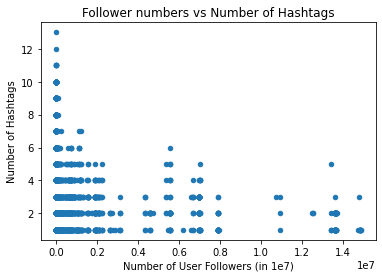

In [15]:
fig, ax = plt.subplots()
followers_and_hashtags.plot(x="user_followers", y = "hashtags_count",
                            kind="scatter", ax = ax)
ax.set_xlabel("Number of User Followers (in 1e7)")
ax.set_ylabel("Number of Hashtags")
ax.set_title("Follower numbers vs Number of Hashtags")

In [17]:
# most common words
words_dict = {}
for text in tweets["text"].values:
    for word in text.split():
        if word in stopwords.words("english"):
            continue
        if word not in words_dict:
            words_dict[word] = 0
        words_dict[word] += 1 
most_common = sorted(words_dict.items(), key = lambda x : x[1], reverse=True)
most_common[:10]

[('vaccine', 6359),
 ('moderna', 4016),
 ('covid19', 2682),
 ('covaxin', 2535),
 ('pfizerbiontech', 2405),
 ('first', 2157),
 ('dose', 1772),
 ('sputnikv', 1678),
 ('vaccines', 1360),
 ('got', 1082)]

(-0.5, 399.5, 199.5, -0.5)

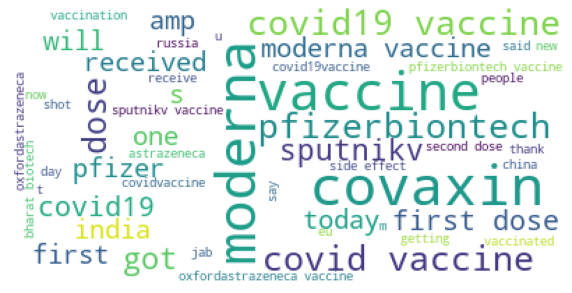

In [18]:
# word cloud text

all_tweets = "".join(rev for rev in tweets["text"])
fig, ax = plt.subplots(figsize = (10,10))
wordcloud_img = WordCloud(max_font_size = 40, max_words = 50, background_color = "white").generate(all_tweets)
ax.imshow(wordcloud_img)
ax.axis("off")

In [ ]:
# word cloud hashtags

all_tweets = "".join(rev for rev in tweets["text"])
fig, ax = plt.subplots(figsize = (10,10))
wordcloud_img = WordCloud(max_font_size = 40, max_words = 50, background_color = "white").generate(all_tweets)
ax.imshow(wordcloud_img)
ax.axis("off")